<a href="https://colab.research.google.com/github/AIandAutomationTools/ai-quartet-evaluator/blob/main/ai_quartet_cleaned_pitch_analysis_version5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎵 AI Quartet Pitch Analysis
This notebook compares a student's pitch to a professor's using a Google Drive MP3 link for each.

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import os

In [ ]:
def load_audio_from_url(url):
    if not url:
        raise ValueError("❌ Missing URL input.")
    try:
        print(f"🔗 Attempting to download: {url}")
        response = requests.get(url)
        response.raise_for_status()
        audio_data = io.BytesIO(response.content)
        audio, sr = librosa.load(audio_data, sr=None)
        return audio, sr
    except Exception as e:
        raise RuntimeError(f"❌ Failed to load audio from {url}\nError: {e}")

In [ ]:
# Replace with actual URLs or use os.environ.get("professor_url")
professor_url = "https://drive.google.com/uc?export=download&id=19GFc2yNb-voEjsczGtxcK_No4XGDS7Wp"
student_url = "https://drive.google.com/uc?export=download&id=1Jp3Ppinl7HRPn4XwKcMj6rFMvcfzfp1p"

print("Professor URL:", professor_url)
print("Student URL:", student_url)

Professor URL: https://drive.google.com/uc?export=download&id=19GFc2yNb-voEjsczGtxcK_No4XGDS7Wp
Student URL: https://drive.google.com/uc?export=download&id=1Jp3Ppinl7HRPn4XwKcMj6rFMvcfzfp1p


In [ ]:
prof_audio, sr1 = load_audio_from_url(professor_url)
stud_audio, sr2 = load_audio_from_url(student_url)

# Resample if needed
if sr1 != sr2:
    stud_audio = librosa.resample(stud_audio, orig_sr=sr2, target_sr=sr1)
    sr2 = sr1

🔗 Attempting to download: https://drive.google.com/uc?export=download&id=19GFc2yNb-voEjsczGtxcK_No4XGDS7Wp
🔗 Attempting to download: https://drive.google.com/uc?export=download&id=1Jp3Ppinl7HRPn4XwKcMj6rFMvcfzfp1p


In [ ]:
# Use yin for monophonic pitch detection
prof_pitch = librosa.yin(prof_audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr1)
stud_pitch = librosa.yin(stud_audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr2)

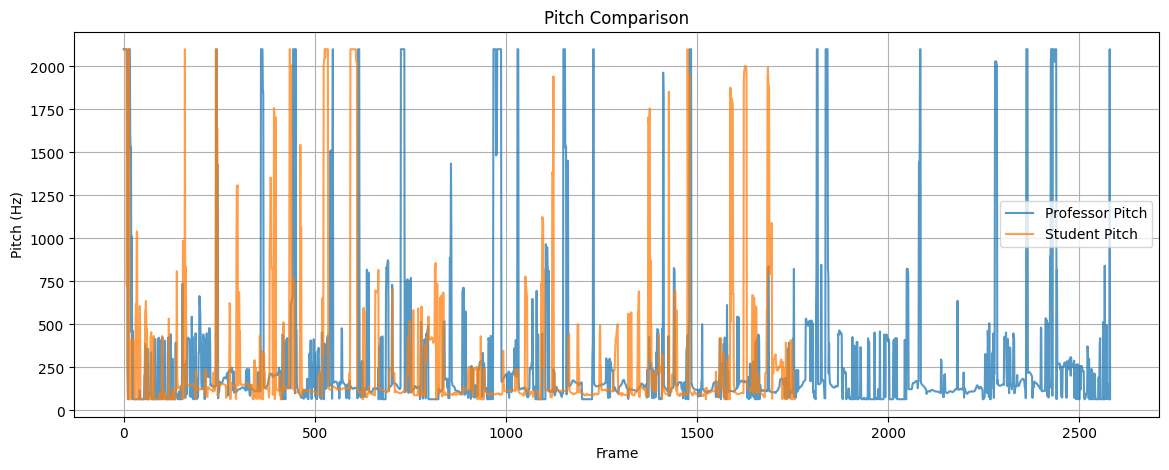

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(prof_pitch, label='Professor Pitch', alpha=0.75)
plt.plot(stud_pitch, label='Student Pitch', alpha=0.75)
plt.legend()
plt.title("Pitch Comparison")
plt.xlabel("Frame")
plt.ylabel("Pitch (Hz)")
plt.grid()
plt.show()

In [ ]:
prof_pitch_clean = np.nan_to_num(prof_pitch)
stud_pitch_clean = np.nan_to_num(stud_pitch)

# Ensure both pitch arrays are the same length
min_len = min(len(prof_pitch_clean), len(stud_pitch_clean))
prof_pitch_clean = prof_pitch_clean[:min_len]
stud_pitch_clean = stud_pitch_clean[:min_len]

# Now compute pitch difference
pitch_diff = np.abs(prof_pitch_clean - stud_pitch_clean)

pitch_diff = np.abs(prof_pitch_clean - stud_pitch_clean)
avg_error = np.mean(pitch_diff)

# Analyze pitch deviations over time
time_per_frame = len(stud_audio) / sr2 / len(stud_pitch_clean)
significant_errors = []

for i, diff in enumerate(pitch_diff):
    if diff > 50:  # Threshold for "significant" error
        timestamp = round(i * time_per_frame, 1)
        significant_errors.append(timestamp)

# Group timestamps into continuous segments
from itertools import groupby
from operator import itemgetter

segments = []
for k, g in groupby(enumerate(significant_errors), lambda x: x[0] - x[1]):
    group = list(map(itemgetter(1), g))
    if group:
        start = group[0]
        end = group[-1]
        if end - start >= 1.5:  # Only include segments > 1.5 seconds
            segments.append((start, end))

# Provide localized feedback
print("\n🎵 Average pitch difference: {:.2f} Hz".format(avg_error))

if segments:
    print("⚠️ Detailed pitch feedback (segments with >1.5s deviation):")
    for start, end in segments:
        print(f" - Pitch off between {start:.1f}s and {end:.1f}s")
elif avg_error > 100:
    print("⚠️ Pitch is consistently off — not just in isolated areas. Focus on tuning accuracy throughout the piece.")
else:
    print("✅ No major localized pitch issues detected.")





print(f"\n🎵 Average pitch difference: {avg_error:.2f} Hz")
if avg_error < 20:
    print("🎯 Great job! Your pitch closely matches the reference.")
elif avg_error < 50:
    print("👍 You're in the ballpark, but there’s room for improvement.")
else:
    print("⚠️ Your pitch deviates significantly. Focus on tuning and accuracy.")


✅ No major localized pitch issues detected.

🎵 Average pitch difference: 287.92 Hz
⚠️ Your pitch deviates significantly. Focus on tuning and accuracy.
